In [ ]:
import os
# os.chdir("../")
# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

from config import *
from data import *
from train import *
from eval import *
from generation import *
from vital2d import *
print("using device: ", device)

# Configuration (customizable)

In [16]:

overwrite = True
model_name = 'tmp' 


text1 = 'The time series exhibits a upward linear trend.'
text2 = 'The time series exhibits a seasonal pattern.'
text3 = 'The mean of the time series shifts over time.'
counter_text1 = 'The time series exhibits a downward linear trend.'
counter_text2 = 'No seasonal pattern.'
counter_text3 = 'No sharp shifts.'

text_config = {'text_pairs': [
                    [text1, counter_text1],
                    [text2, counter_text2],
                    [text3, counter_text3]
                ], 
                'n': None, # number of samples of each segment in mixture of text
               'weights': [2, 1, 1]}

update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'segment3',
    y_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    y_pred_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    # txt2ts
    txt2ts_y_cols = ['segment1', 'segment2', 'segment3'],
    
    
    # Data settings
    text_col = 'text', #'ts_description',
    seq_length = 200,
    downsample = True,
    downsample_size = 1000,
    downsample_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    custom_target_cols = ['segment1', 'segment2', 'segment3', 'label'], # 'label' is the same as the default "by_label" target
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = False,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 50,
    alpha = 1/100,
    num_saves = 3,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()


# Data

In [ ]:
# change data preparation for a given experiment
with open('prepare_experiment/synthetic.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())

text
The time series exhibits a upward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts over time.      10000
The time series exhibits a upward linear trend. The time series exhibits a seasonal pattern. No sharp shifts.                                   10000
The time series exhibits a upward linear trend. No seasonal pattern. The mean of the time series shifts over time.                              10000
The time series exhibits a upward linear trend. No seasonal pattern. No sharp shifts.                                                           10000
The time series exhibits a downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts over time.    10000
The time series exhibits a downward linear trend. The time series exhibits a seasonal pattern. No sharp shifts.                                 10000
The time series exhibits a downward linear trend. No seasonal pattern. The mean of the time ser

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Model (customizable)

In [ ]:
# customize encoder and decoder here. 
ts_encoder = CNNEncoder(ts_dim = ts_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[4], kernel_size=50, dropout=0)
ts_decoder = None # default decoder
text_encoder = TextEncoderCNN(text_dim = tx_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[4], kernel_size=50, dropout=0)
# overwrite = False
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                   Param #
VITAL                                    1
├─TSVAEEncoder: 1-1                      --
│    └─LocalNorm: 2-1                    --
│    └─CNNEncoder: 2-2                   --
│    │    └─Sequential: 3-1              205,524
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
├─TextEncoder: 1-2                       --
│    └─TextEncoderCNN: 2-5               --
│    │    └─Sequential: 3-2              787,156
├─TSVAEDecoder: 1-3                      --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-3                  131,328
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  65,792
│    │    └─LeakyReLU: 3-6               --
│    │    └─Linear: 3-7                  51,400
Total params: 1,766,513
Trainable params: 1,766,513
Non-trainable params: 0


# Train

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500]
	Training Loss: 1231.572388 (clip: 1219.419739, vae: 1215.266541)
	Testing Loss: 1234.913818 (clip: 1222.876221, vae: 1203.762573)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [11/500]
	Training Loss: 1231.576294 (clip: 1219.486938, vae: 1208.935303)
	Testing Loss: 1231.422546 (clip: 1219.440002, vae: 1198.250549)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [21/500]
	Training Loss: 1233.658264 (clip: 1221.624329, vae: 1203.393860)
	Testing Loss: 1234.155518 (clip: 1222.215820, vae: 1193.971069)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [31/500]
	Training Loss: 1229.938477 (clip: 1217.939270, vae: 1199.920776)
	Testing Loss: 1227.668762 (clip: 1215.762939, vae: 1190.582520)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [41/500]
	Training Loss: 1228.545349 (clip: 1216.588745, vae: 1195.658813)
	Testing Loss: 1223.371826 (clip: 1211.502563, vae: 1186.929932)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [51/500]
	Training Loss: 1224.360168 (clip: 1212.450500, vae: 1190.971802)


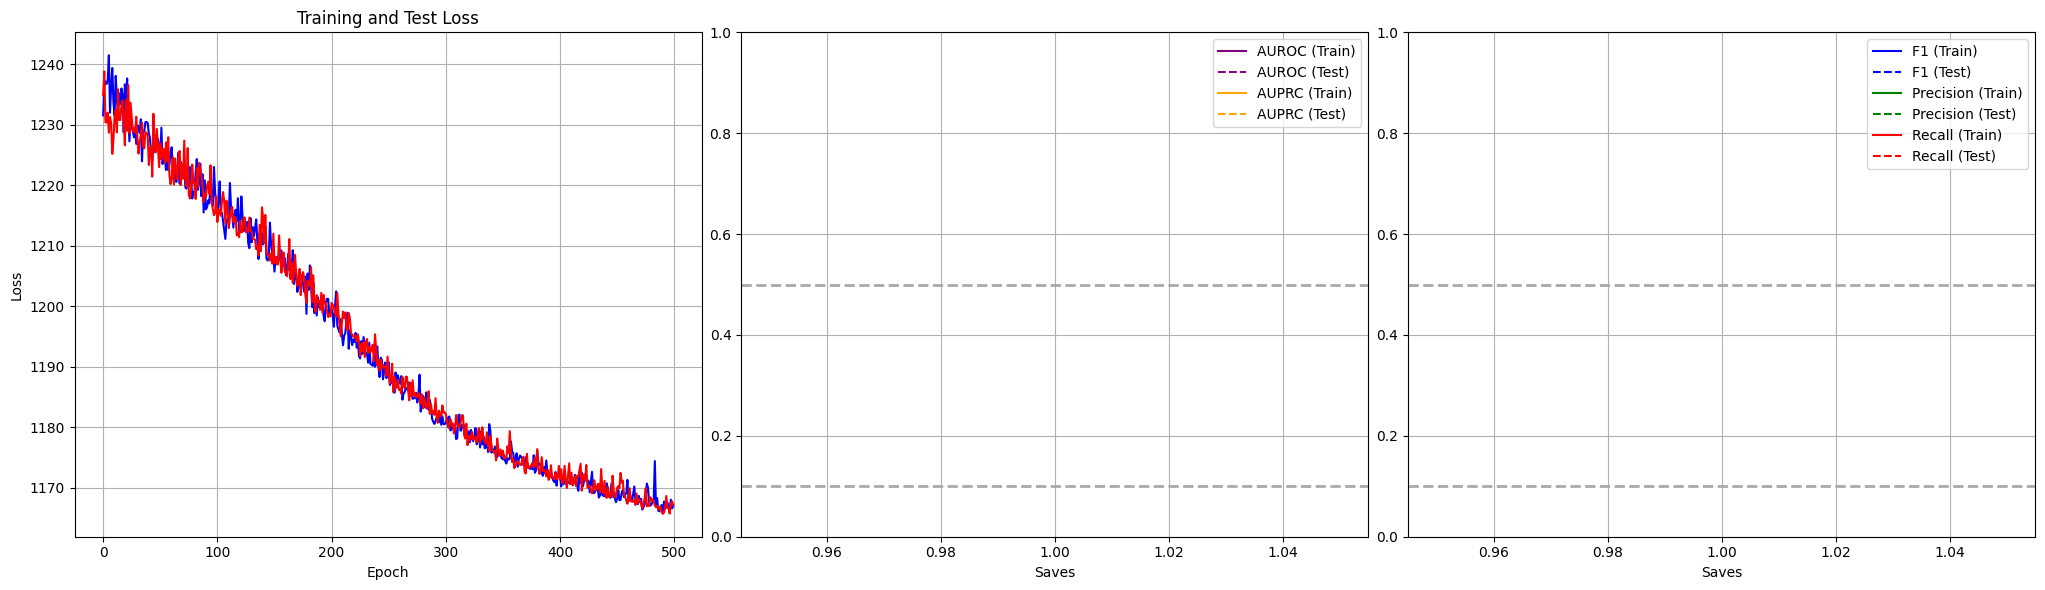

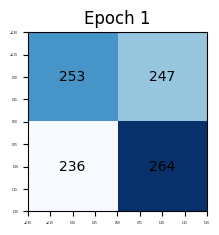

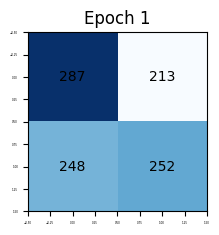

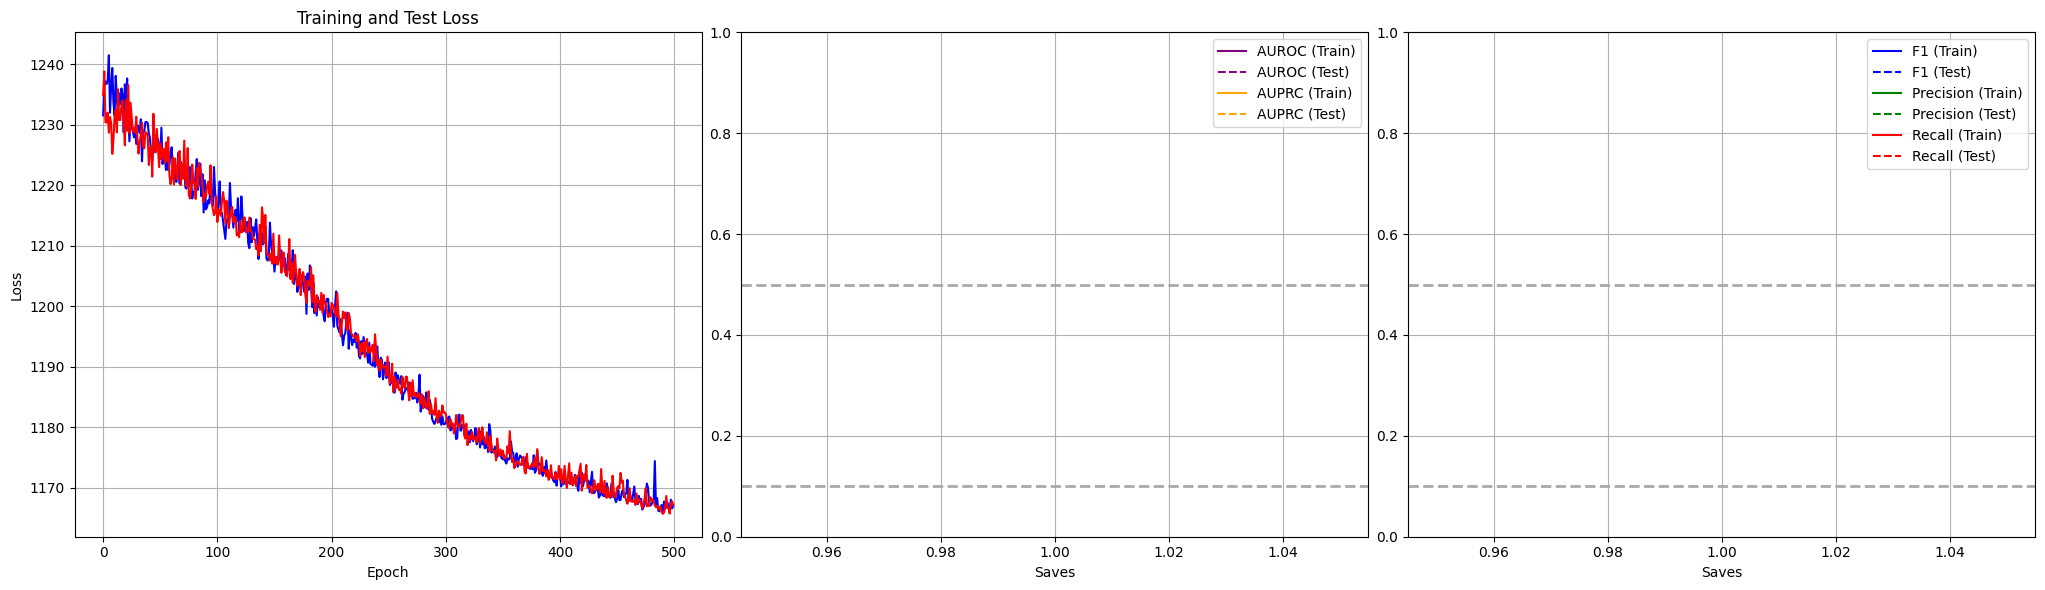

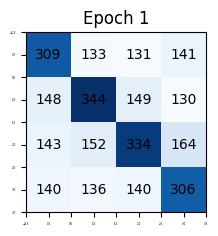

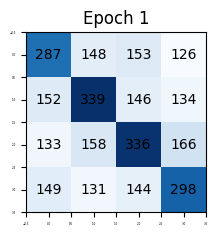

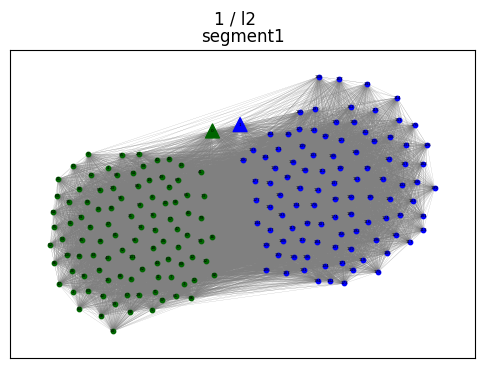

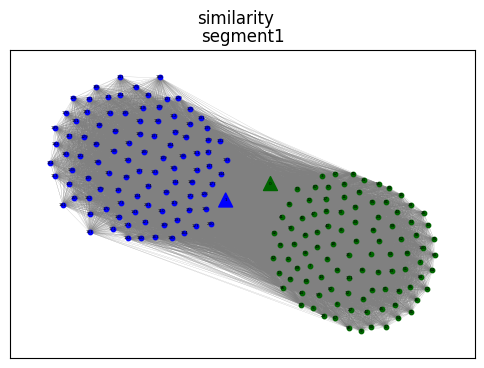

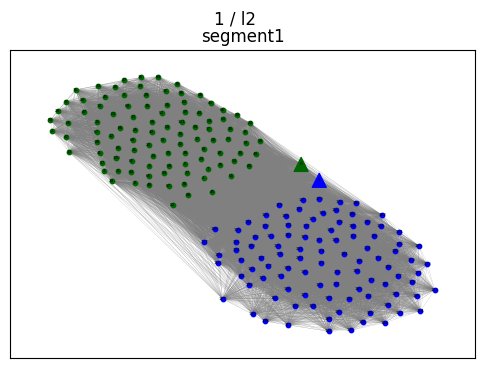

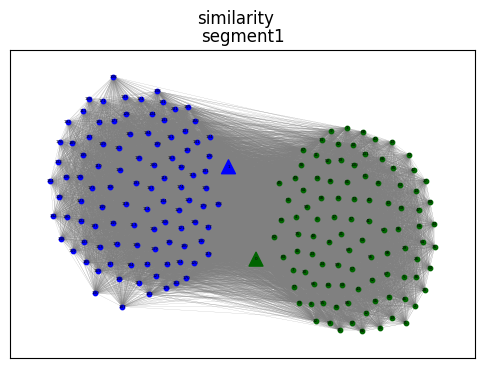

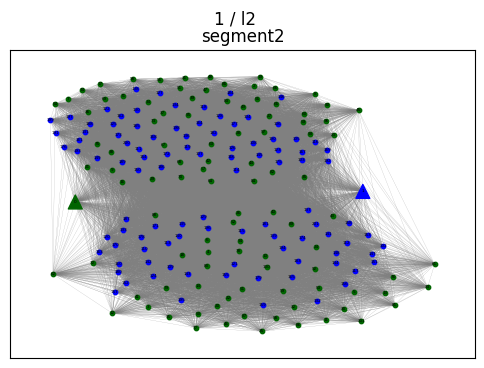

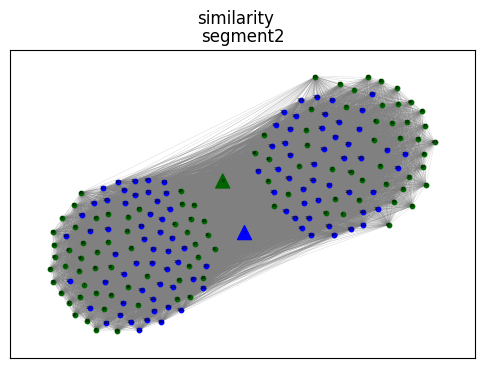

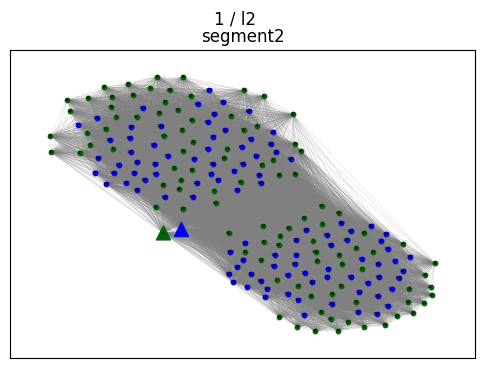

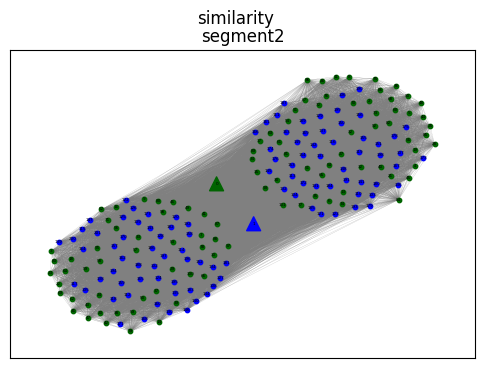

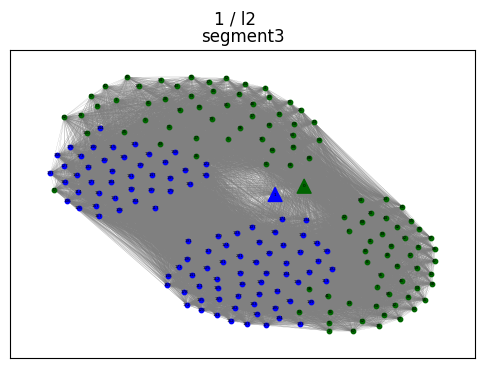

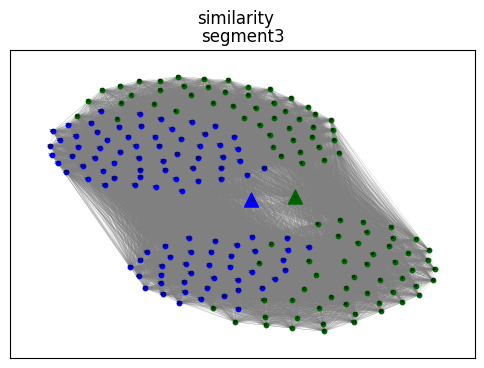

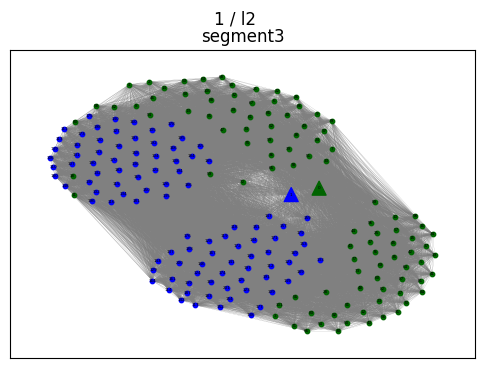

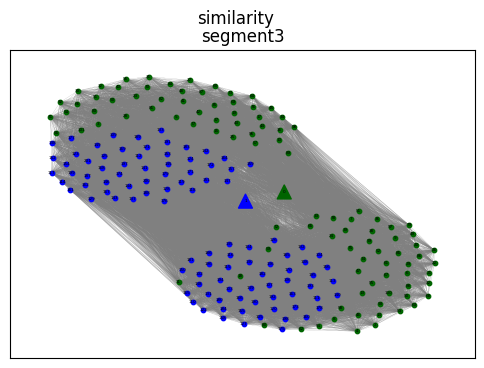

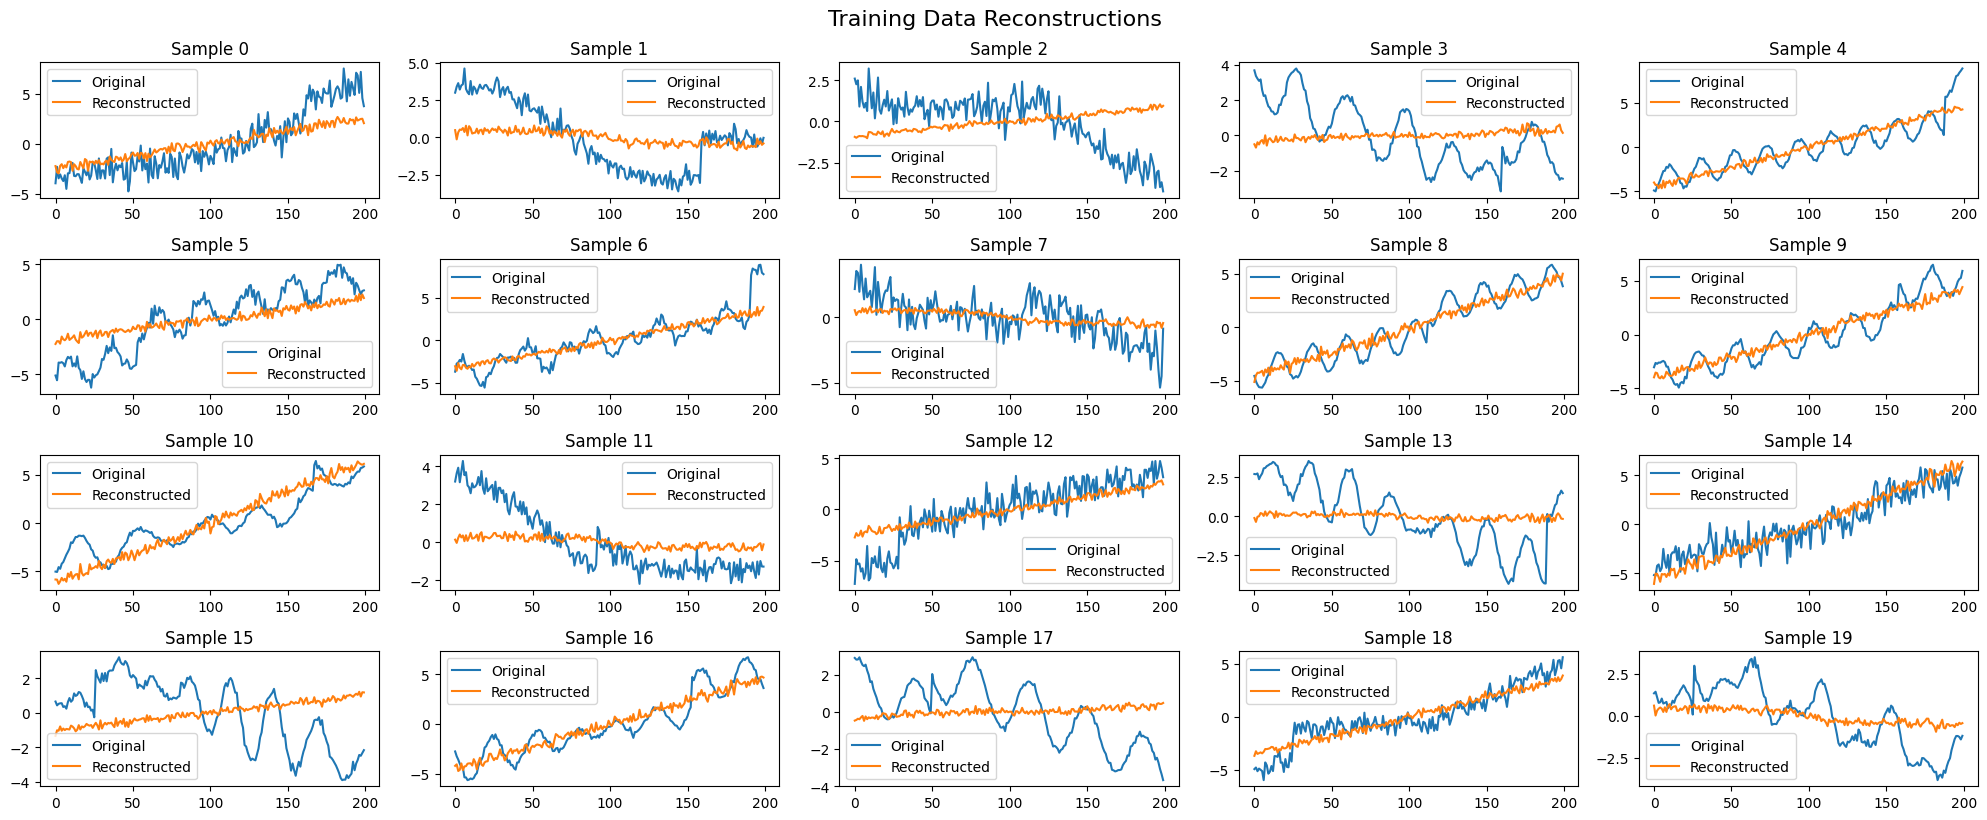

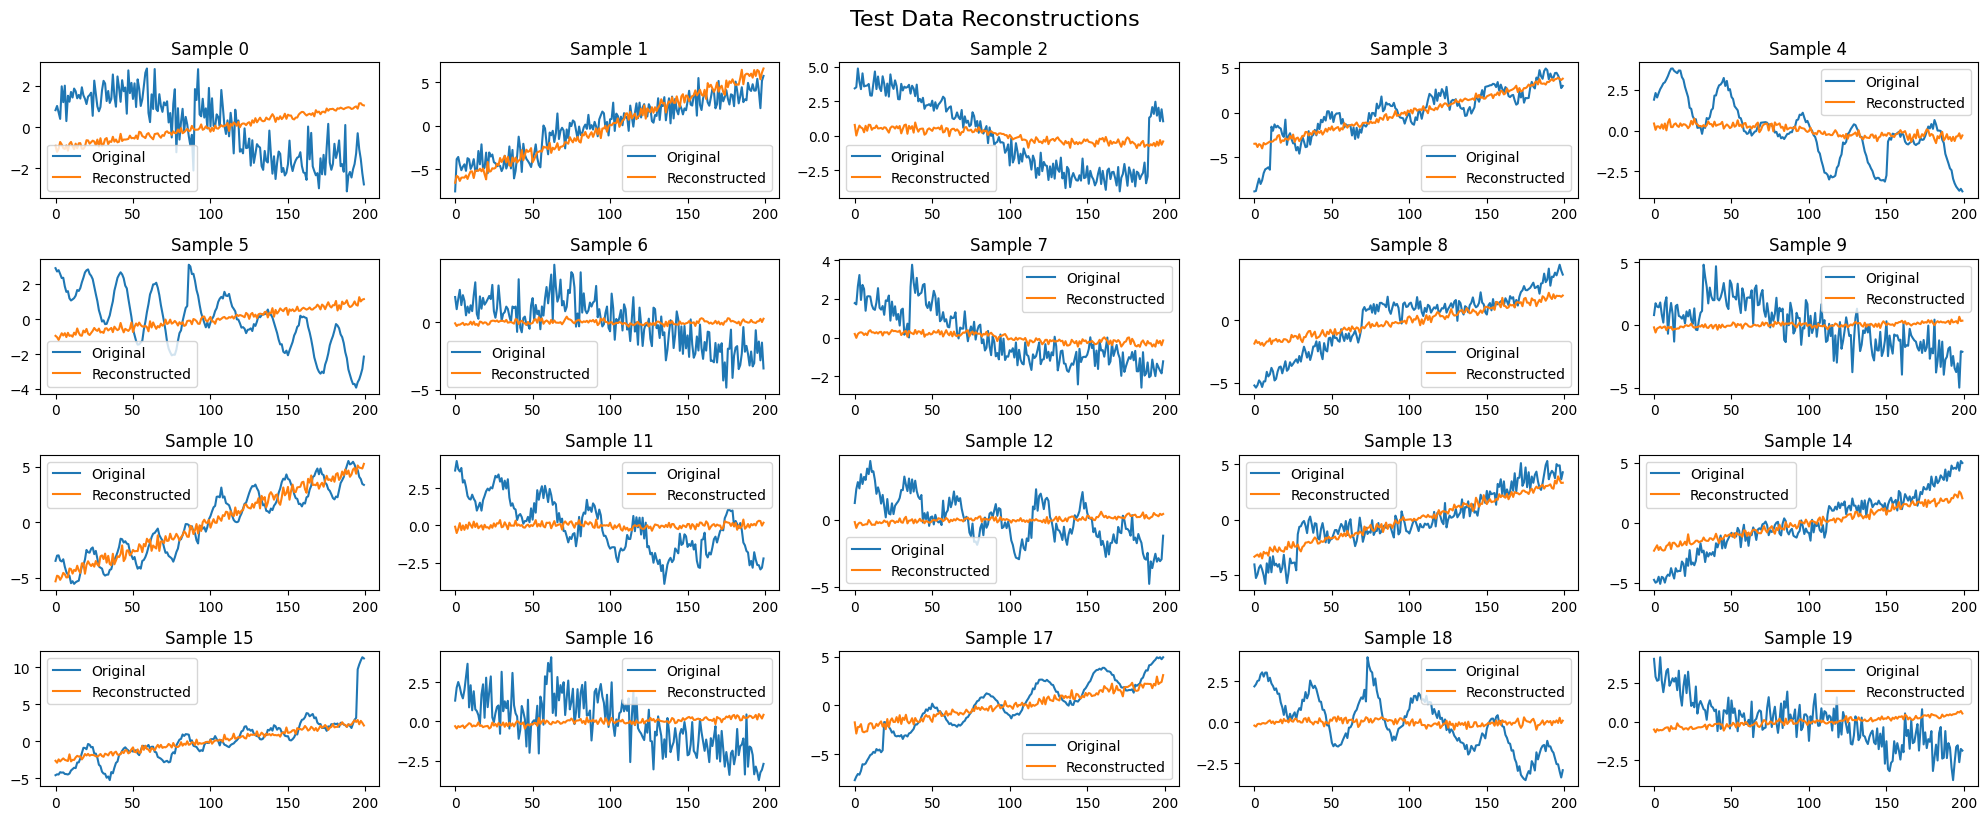

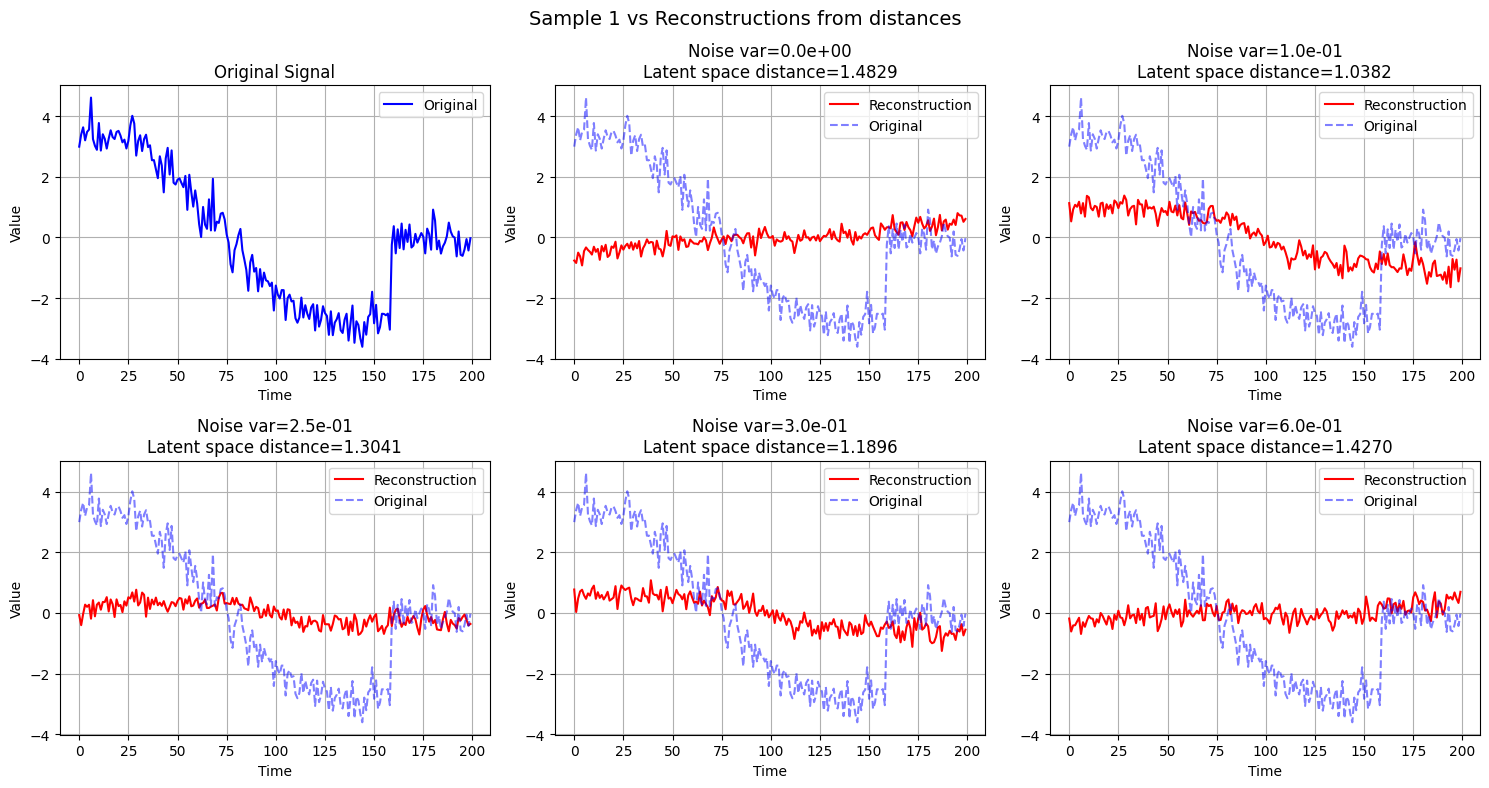

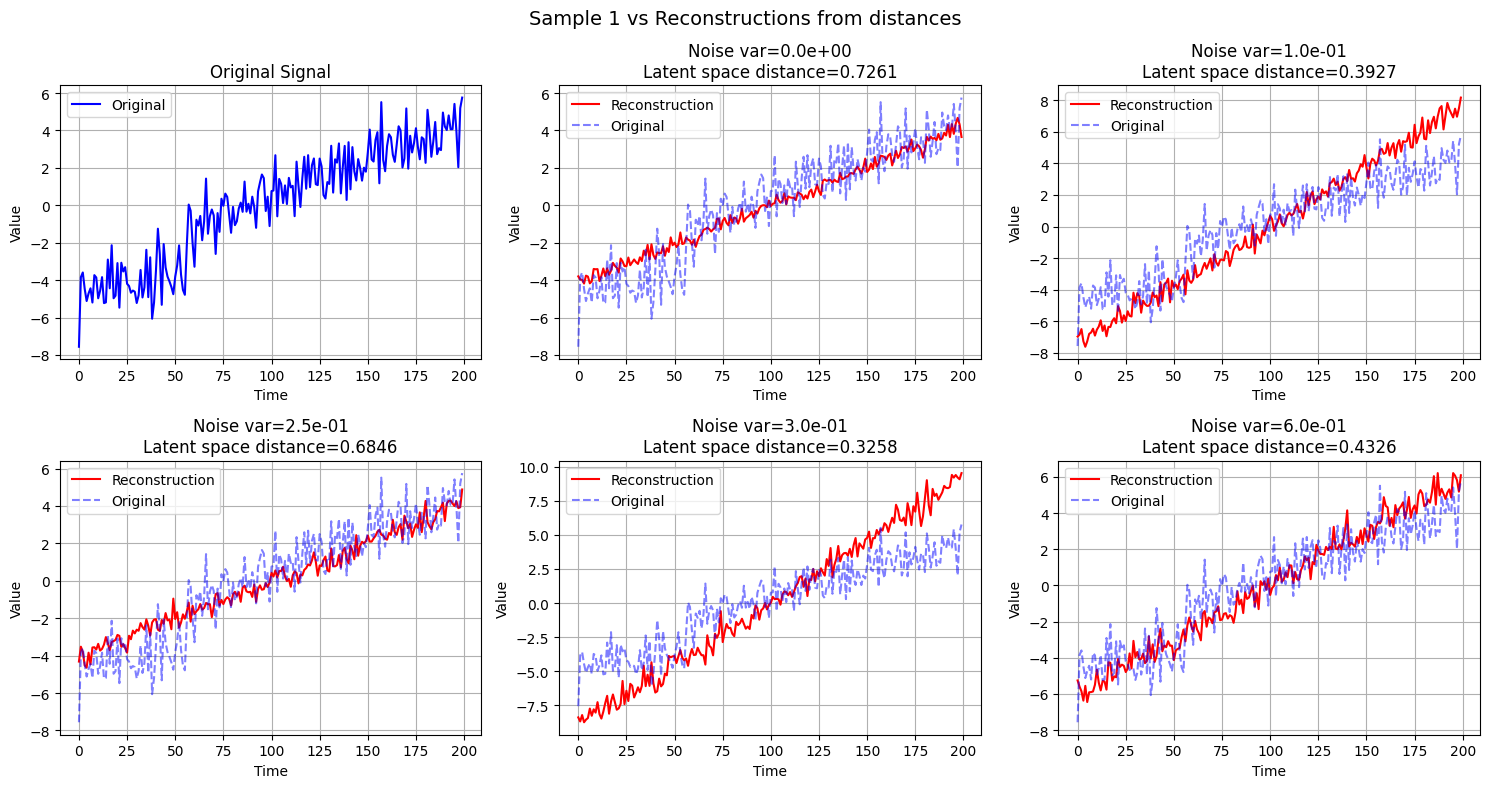

Epoch [1/500]
	Training Loss: 1166.217712 (clip: 1159.865173, vae: 635.251923)
	Testing Loss: 1167.979675 (clip: 1161.486816, vae: 649.284637)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [11/500]
	Training Loss: 1164.999084 (clip: 1158.669434, vae: 632.962189)
	Testing Loss: 1166.483459 (clip: 1159.991638, vae: 649.184082)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [21/500]
	Training Loss: 1165.968750 (clip: 1159.787903, vae: 618.081818)
	Testing Loss: 1167.122620 (clip: 1160.744629, vae: 637.798920)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [31/500]
	Training Loss: 1163.831360 (clip: 1157.655273, vae: 617.605591)
	Testing Loss: 1164.502319 (clip: 1158.131836, vae: 637.049957)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [41/500]
	Training Loss: 1163.638672 (clip: 1157.560730, vae: 607.790741)
	Testing Loss: 1163.131409 (clip: 1156.902771, vae: 622.865204)
	Learning Rate: 0.000010000
beta: 0.0
Epoch [51/500]
	Training Loss: 1163.882019 (clip: 1157.825134, vae: 605.688263)
	Testing Lo

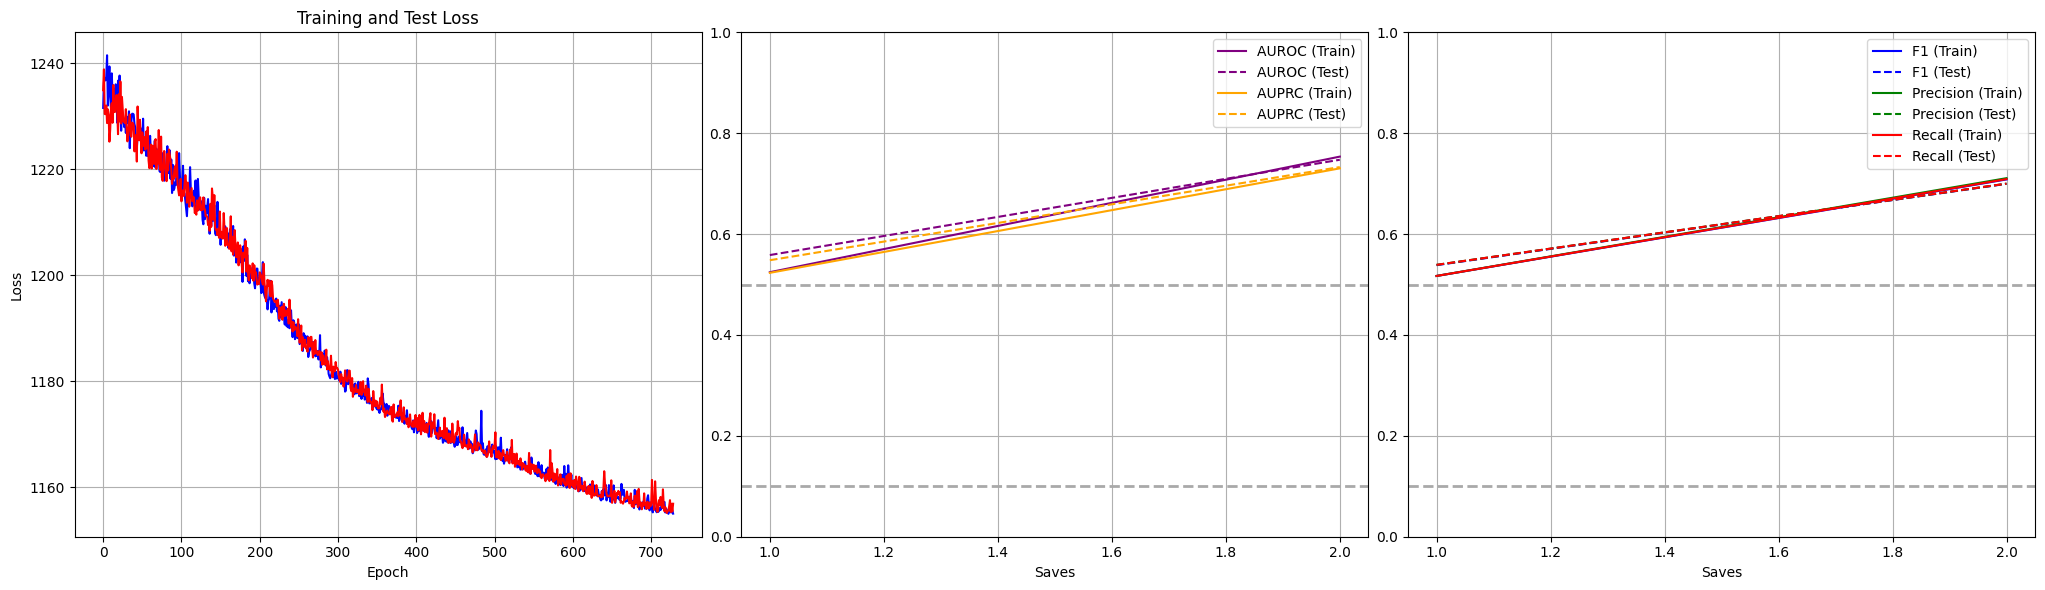

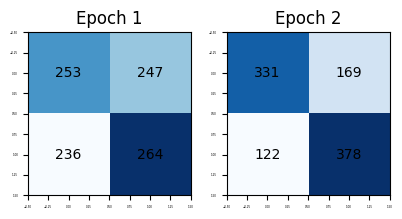

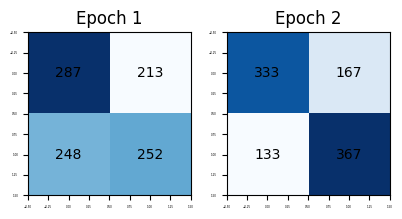

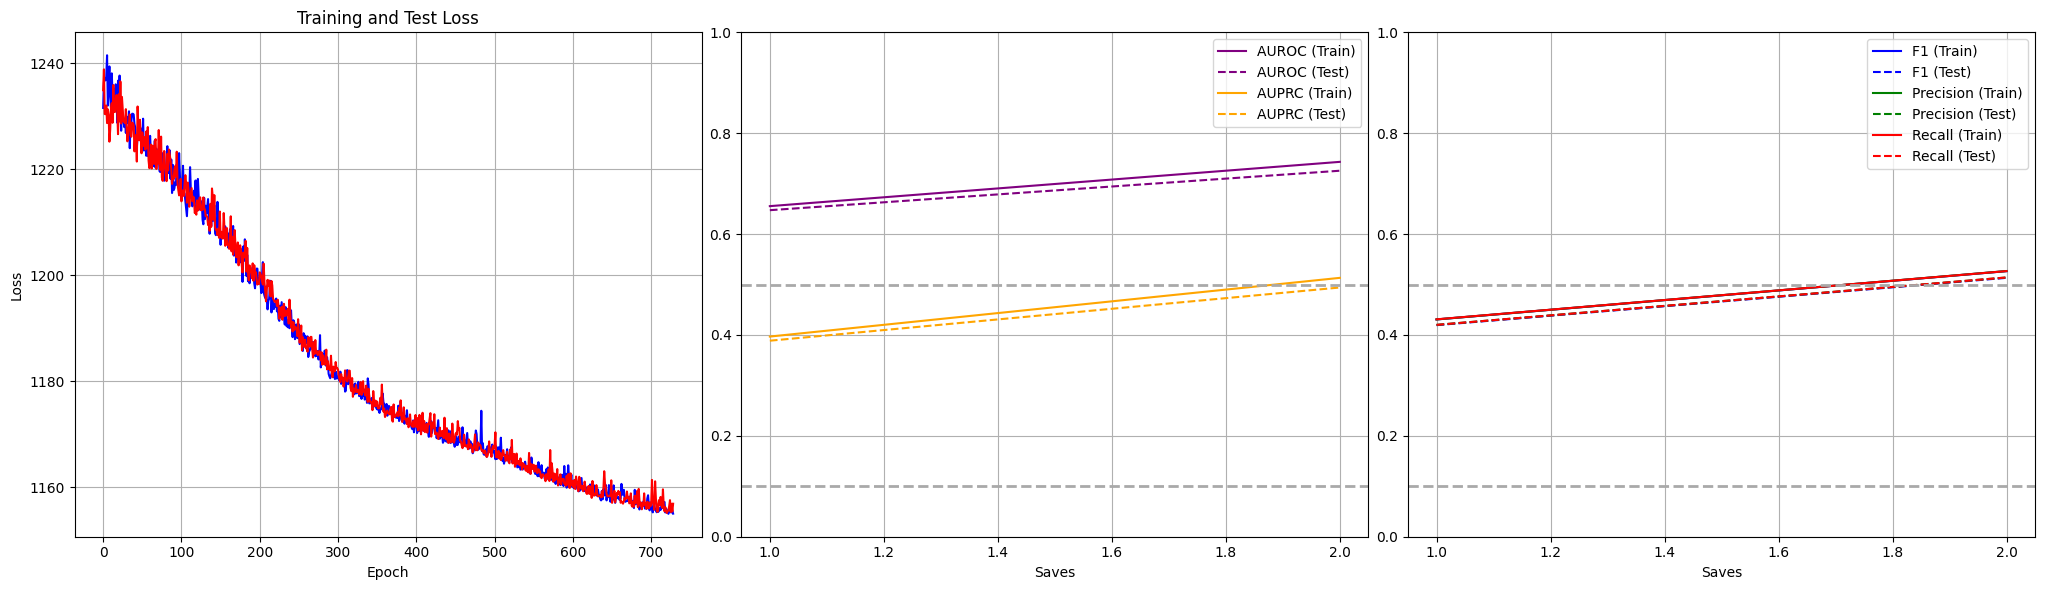

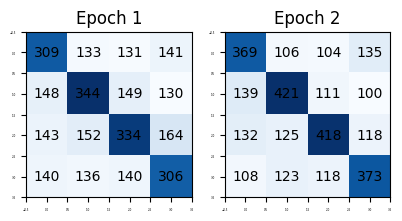

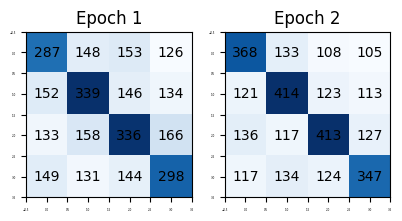

In [ ]:
# overwrite = False
with open('run/train.py', 'r') as file:
    exec(file.read())


# Diagnose

In [6]:
# pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
# for i in range(95, 105):
#     print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])
    
# for i in range(95, 105):
#     print(ts2tx_distances['l2']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['l2']['Low amount of consecutive increases.'][i])

# Generation

0    The time series exhibits a upward linear trend.
Name: segment1, dtype: object


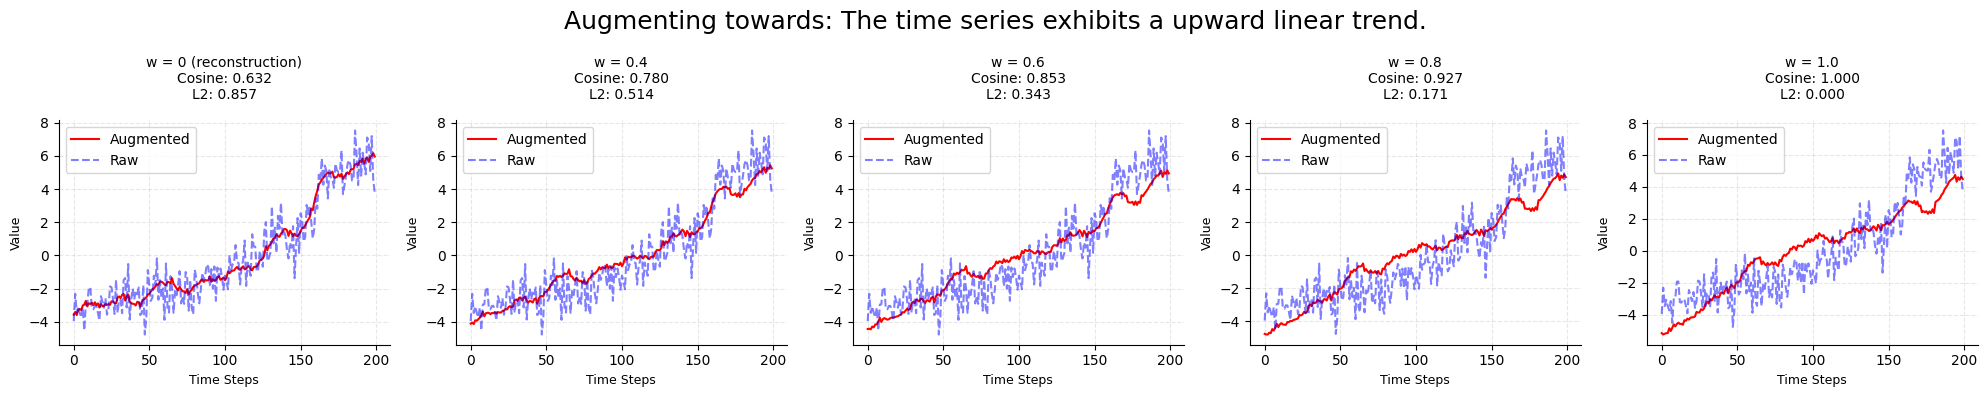

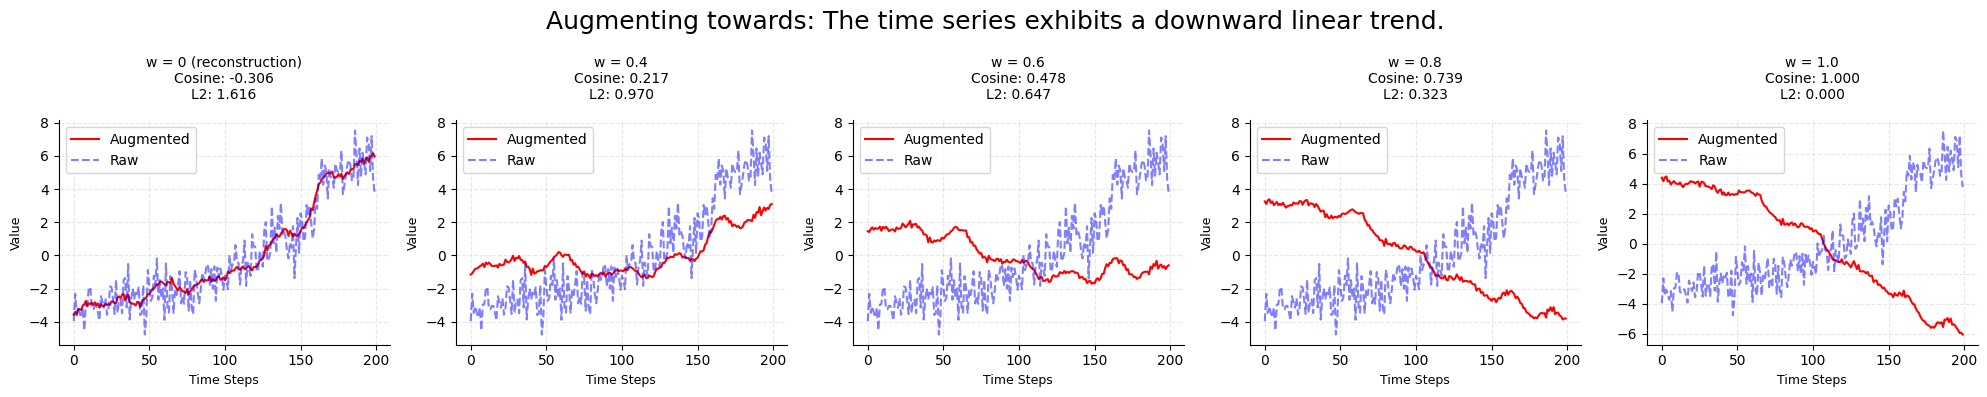

0    The time series exhibits a downward linear trend.
Name: segment1, dtype: object


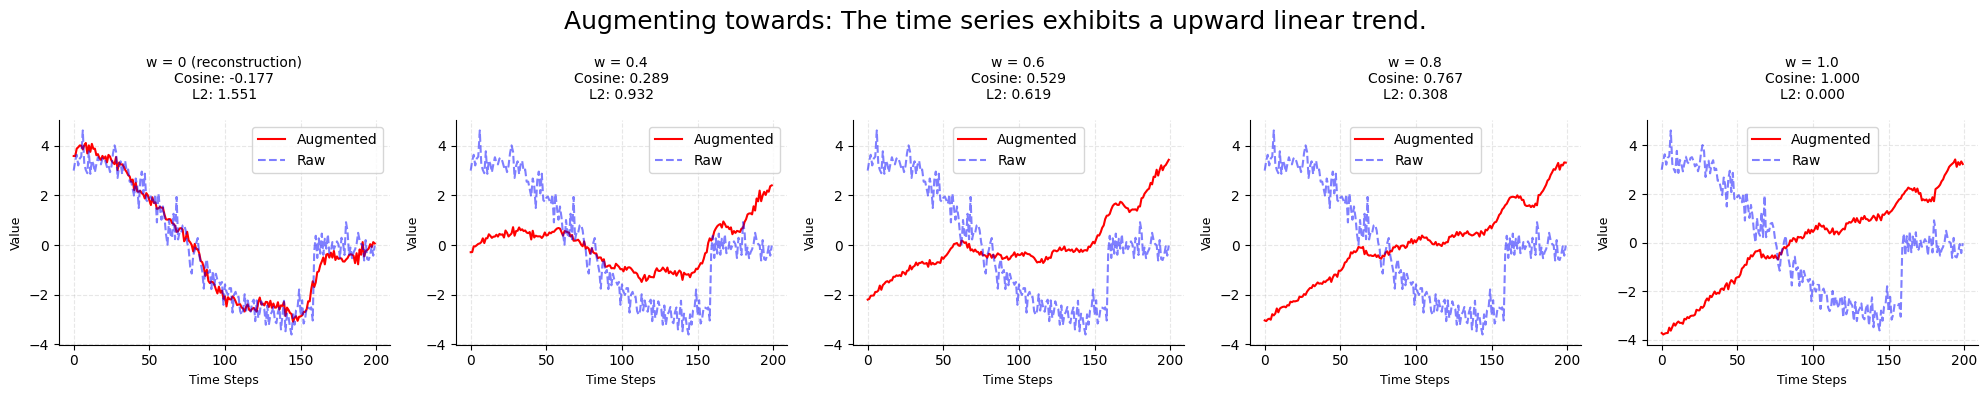

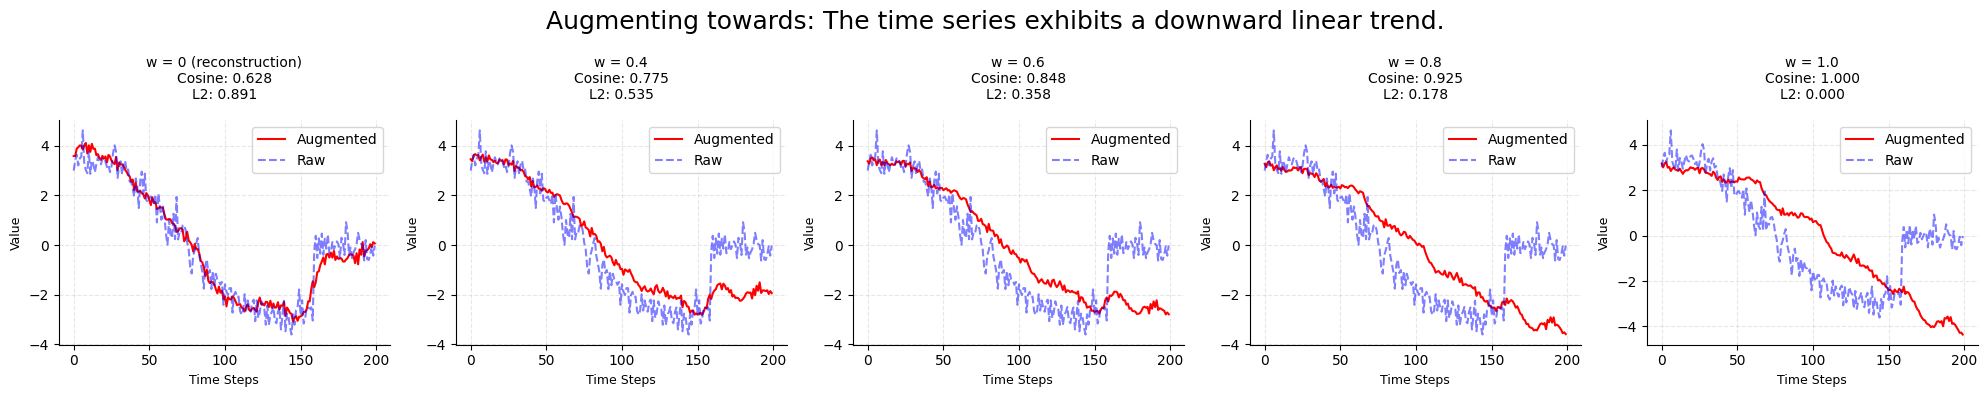

0    No seasonal pattern.
Name: segment2, dtype: object


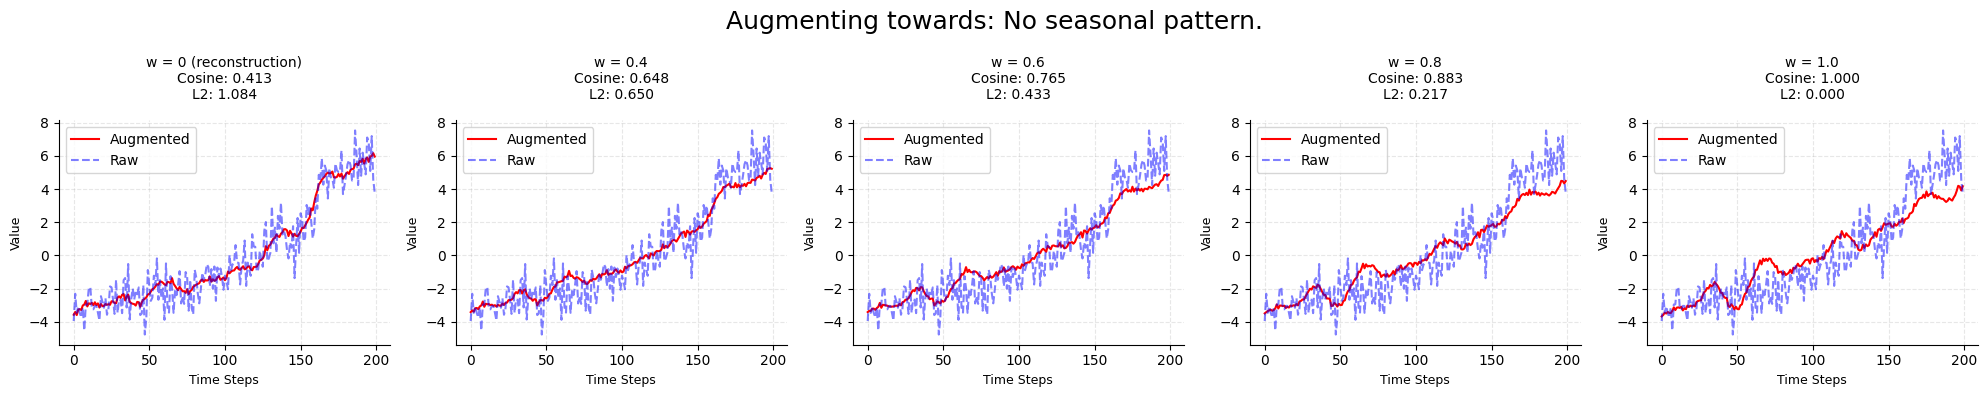

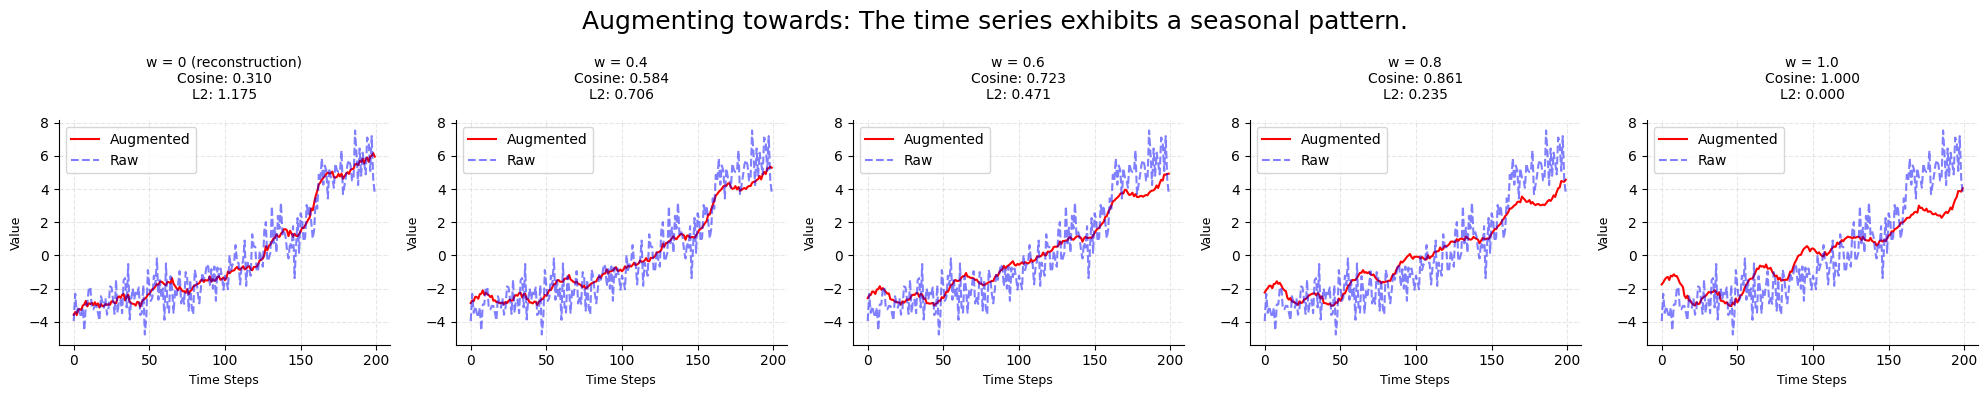

0    The time series exhibits a seasonal pattern.
Name: segment2, dtype: object


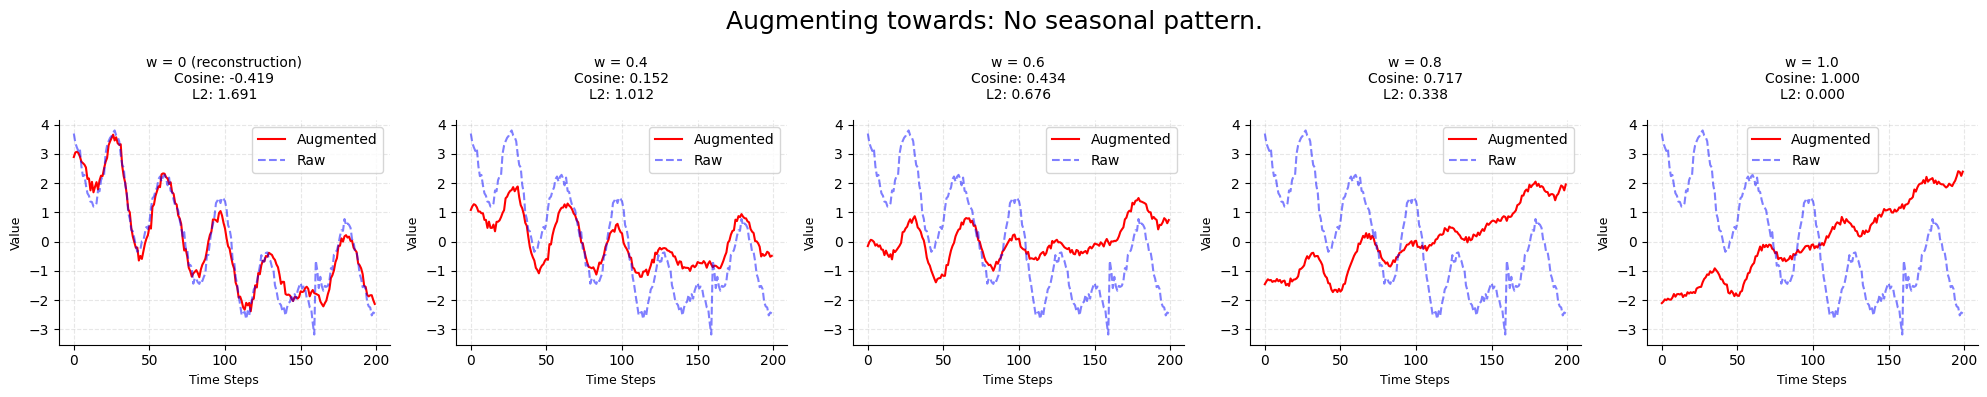

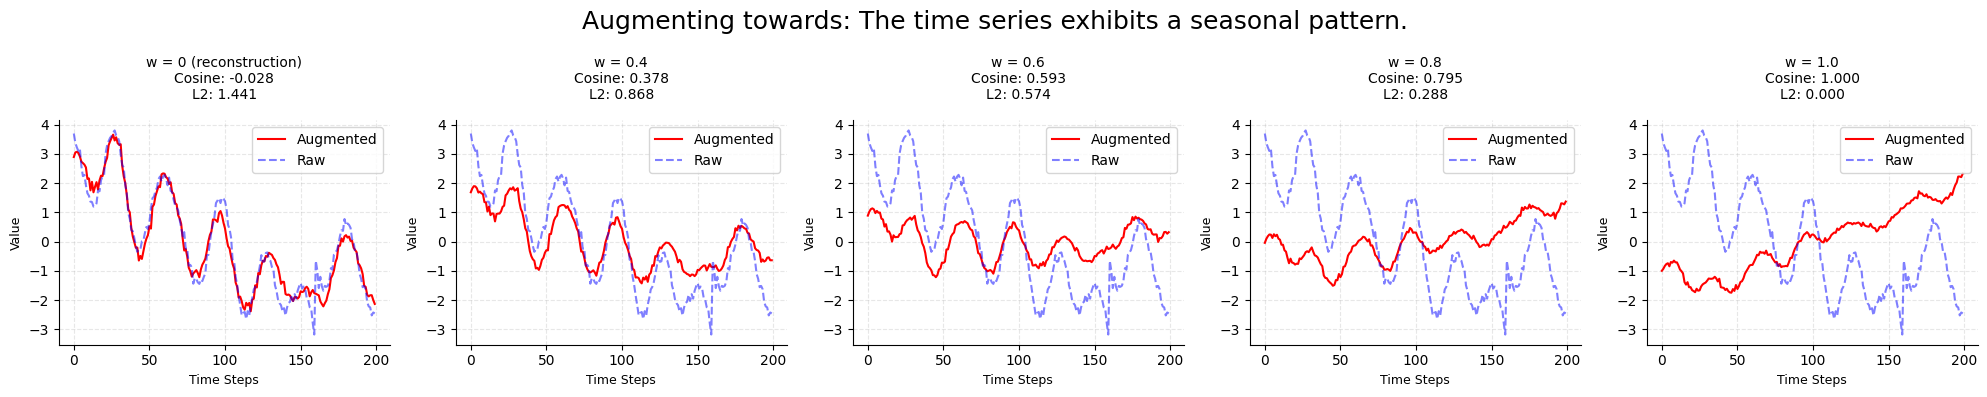

0    The mean of the time series shifts over time.
Name: segment3, dtype: object


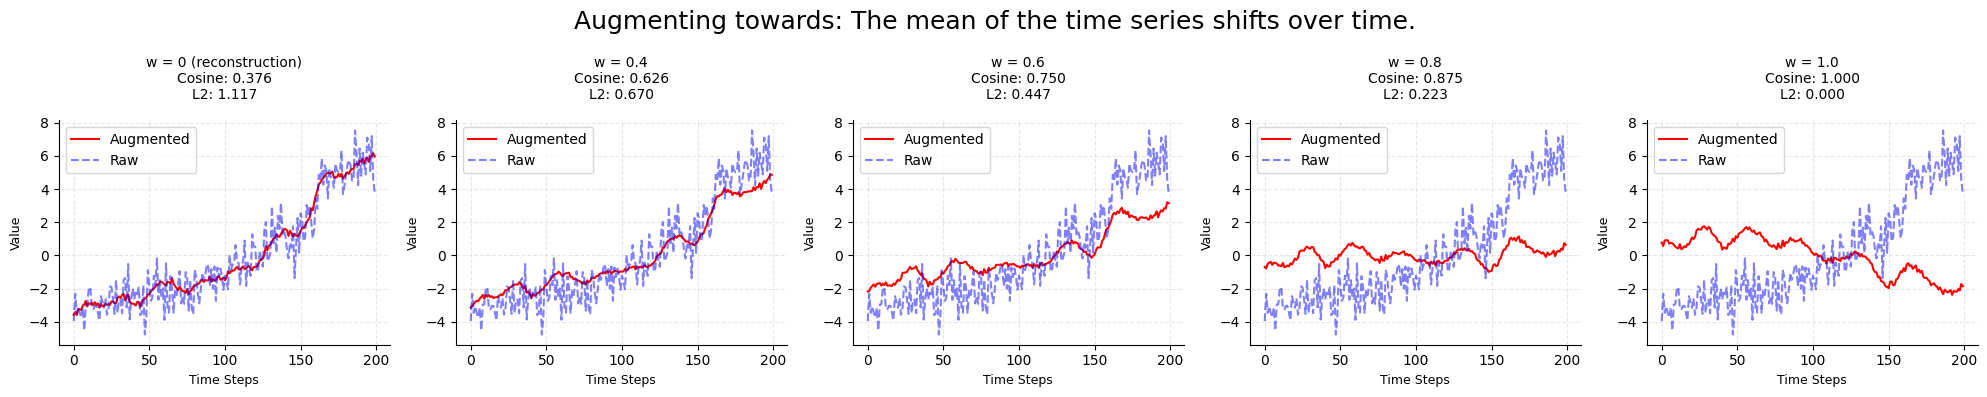

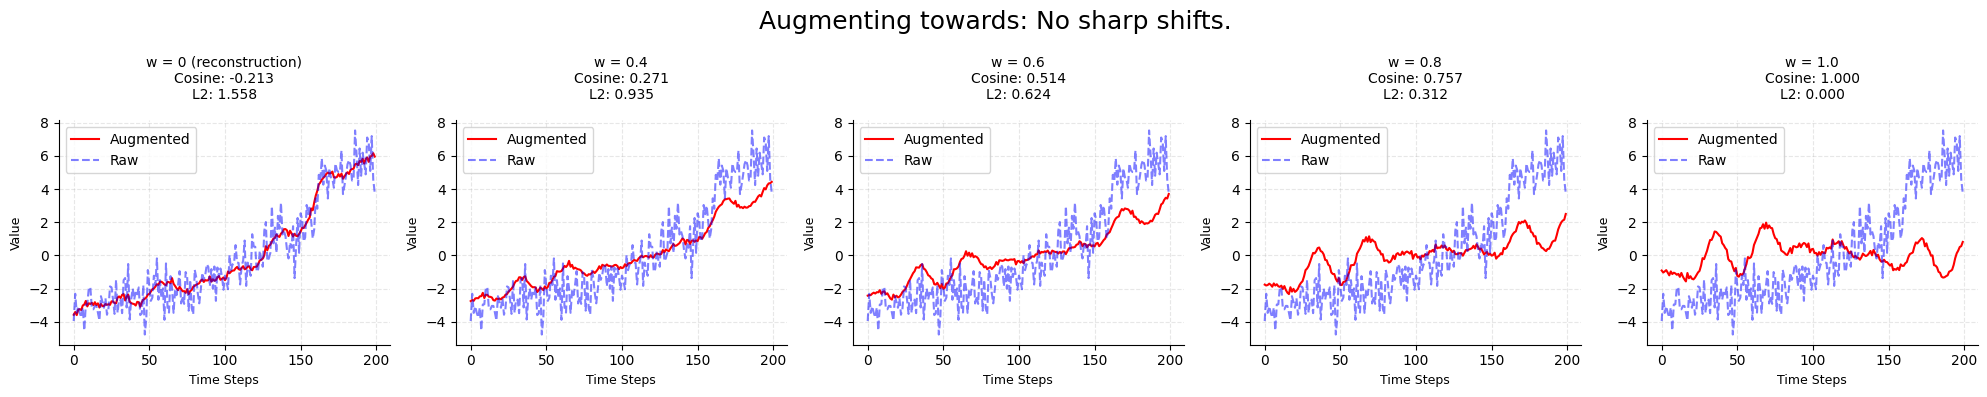

0    No sharp shifts.
Name: segment3, dtype: object


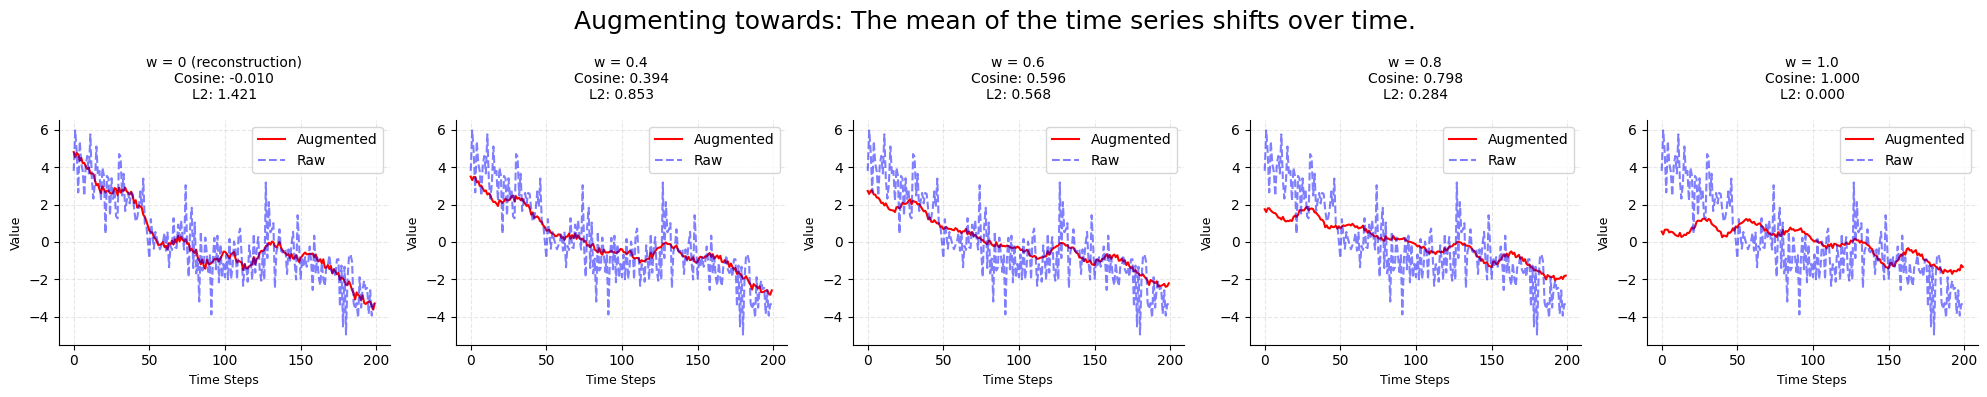

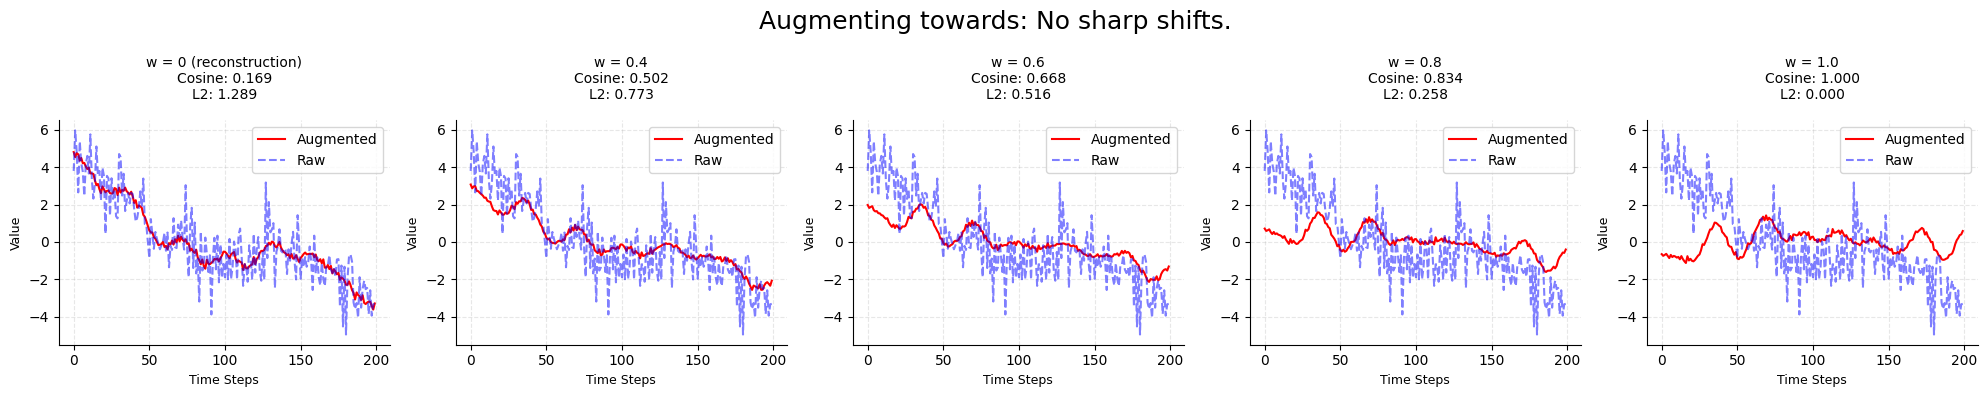

In [15]:
tid = 0

y_levels = config_dict['y_levels']
y_col = config_dict['y_col']

for y_col in [col for col in config_dict['custom_target_cols'] if col != 'label']:
    y_levels = list(df_train[y_col].unique())
    df_train_ls = []
    df_test_ls = []
    for i in range(len(y_levels)):
        df_train_ls.append(df_train[df_train[y_col] == y_levels[i]].reset_index(drop=True))
        df_test_ls.append(df_test[df_test[y_col] == y_levels[i]].reset_index(drop=True))


    for i in range(len(y_levels)):
        df = df_train_ls[i].iloc[[tid]].copy()
        print(df[y_col])
        for j in range(len(y_levels)):
            df['text' + str(j)] = y_levels[j]
        text_cols = ['text' + str(j) for j in range(len(y_levels))]
        w_values = np.arange(0.4, 1.2, 0.2)
        w_values = np.concatenate([[0], w_values])
        plot_interpolate_ts_tx_ws(df, model, config_dict, text_cols, w_values = w_values, label = True)


In [9]:
df['text'].tolist()

['The time series exhibits a downward linear trend. No seasonal pattern. No sharp shifts.']

In [10]:
df_train[y_col]

23534    The mean of the time series shifts over time.
65194    The mean of the time series shifts over time.
63167    The mean of the time series shifts over time.
45235    The mean of the time series shifts over time.
6769     The mean of the time series shifts over time.
                             ...                      
34613                                 No sharp shifts.
51008                                 No sharp shifts.
36224                                 No sharp shifts.
58923                                 No sharp shifts.
30718                                 No sharp shifts.
Name: segment3, Length: 1000, dtype: object